# Exercise instructions
1.  You must answer the questions at the beginning of each paragraph  
2.  You must complete the code between #...#
3.  You must explain in comments the lines of code that you produce
4.  You can help and ask for help from others but you must indicate the person who helped you

# Références
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/utils.py



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -o '/content/drive/Othercomputers/My MacBook Pro/My MIR Files/First Semester/Deep Learning/Image segmentation/HorizontalSegmentation/Dataset.zip'
!unzip -o '/content/test_frames.zip'
!unzip -o '/content/test_masks.zip'
!unzip -o '/content/train_frames.zip'
!unzip -o '/content/train_masks.zip'
!unzip -o '/content/val_frames.zip'
!unzip -o '/content/val_masks.zip'

Streaming output truncated to the last 5000 lines.
  inflating: val_frames/val/val_03015.jpg  
  inflating: val_frames/val/val_02321.jpg  
  inflating: val_frames/val/val_02241.jpg  
  inflating: val_frames/val/val_02151.jpg  
  inflating: val_frames/val/val_00011.jpg  
  inflating: val_frames/val/val_01033.jpg  
  inflating: val_frames/val/val_03128.jpg  
  inflating: val_frames/val/val_00581.jpg  
  inflating: val_frames/val/val_01080.jpg  
  inflating: val_frames/val/val_00656.jpg  
  inflating: val_frames/val/val_01705.jpg  
  inflating: val_frames/val/val_02519.jpg  
  inflating: val_frames/val/val_02768.jpg  
  inflating: val_frames/val/val_02445.jpg  
  inflating: val_frames/val/val_01447.jpg  
  inflating: val_frames/val/val_03014.jpg  
  inflating: val_frames/val/val_02299.jpg  
  inflating: val_frames/val/val_01639.jpg  
  inflating: val_frames/val/val_01525.jpg  
  inflating: val_frames/val/val_00854.jpg  
  inflating: val_frames/val/val_02393.jpg  
  inflating: val_frames/v

In [ ]:
project_path = "/content/drive/Othercomputers/My MacBook Pro/My MIR Files/First Semester/Deep Learning/Image segmentation/HorizontalSegmentation"
data_set_path = "/content/"
TRAIN_IMG_DIR = os.path.join(data_set_path,"train_frames/train")
TRAIN_MASK_DIR = os.path.join(data_set_path,"train_masks/train")
VAL_IMG_DIR = os.path.join(data_set_path,"val_frames/val")
VAL_MASK_DIR = os.path.join(data_set_path,"val_masks/val")
CHECKPOINT_PATH = os.path.join(project_path,"Save/my_checkpoint.pth.tar")
PLOT_PATH = os.path.join(project_path,"Save/Accuracy")
PLOT_VAL_PATH = os.path.join(project_path,"Save/validation")

# Dataset
https://research.aimultiple.com/datasets-for-ml/

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pdb
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Dataset Class
Questions:
1. Explain what the get_item function is for and how it is called in training mechanism?

2. why do we have to divide mask by 255?

## Answers


    1. Explain what the get_item function is for and how it is called in training mechanism?


- The __getitem__ method in the HorizonDataset class is used to retrieve a specific data point from the dataset. We call the __getitem__ method it automatically feaches the image and mask pairs during training. When iterating over the DataLoader during training, the method is call for each index to get the data sample for the training process.


    2. why do we have to divide mask by 255?

- The mask is divided by 255 to normalize its pixel values to the range [0, 1]. The intensity of colors is presented by pixel values with a maximum of 255. Dividing the mask value by 255 means normalizing the values for faster convergence during training.


In [ ]:
class HorizonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

# Create a HorizonDataset class that derives from the pytorch Dataset class and complete the __getitem__(self, index) method.
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask, dtype=np.float32)
        mask = mask/255.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
transform = A.Compose([
    # Add your desired transformations here
    A.Resize(256, 256),  # Example transformation
    ToTensorV2()
])

# Initialize your dataset
train_dataset = HorizonDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Test DataLoader
for images, masks in train_loader:
    print("Images batch shape:", images.shape)
    print("Masks batch shape:", masks.shape)
    break  # Only show the first batch

Images batch shape: torch.Size([4, 3, 256, 256])
Masks batch shape: torch.Size([4, 256, 256])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Loader definition
Questions:
1. Explain what the data loader is for?

## Answer

    1. Explain what the data loader is for?

- The data loader is used for handling and preparing the dataset for training. It devide the dataset into batches for easier processing. It is also used for shuffling to make sure the model do not lear the data in the same sequence every time, which helps it learn better.

In [ ]:
# The data loader allows you to iterate over the dataset.
# Each iteration below returns a batch of train_features and train_labels

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HorizonDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

# Warning to shuffle (true or false ??? explain why in commentary)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = HorizonDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )
# Warning to shuffle (true or false ??? explain why in commentary)
    val_loader =  DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

# Model definition
https://www.pinecone.io/learn/batch-layer-normalization/

https://medium.com/data-science-365/batch-normalization-explained-in-plain-english-3436014f9e52

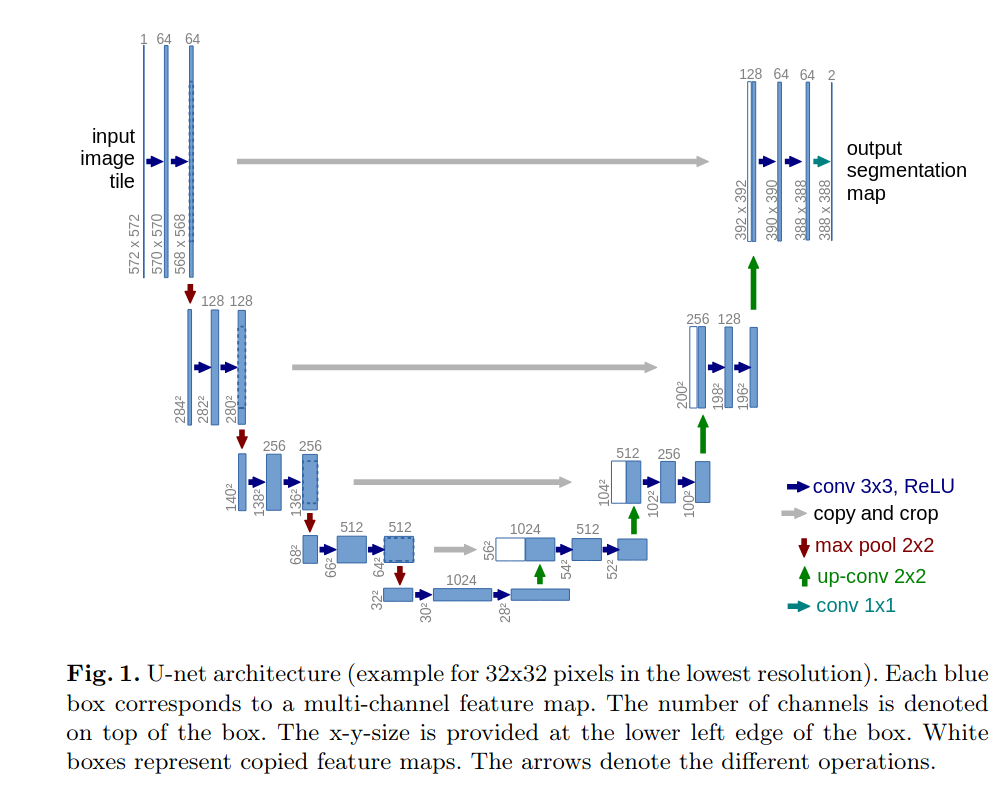

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# explain the line of code below
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Double convolution
Questions:
1. From the network diagram above, code an elementary brick composed of a convolution layer.Do the same but limiting to a single convolution layer.

- The two classes represent different neural network layers: DoubleConv and SimpleConv.

- The DoubleConv class is an "elementary brick" consisting of two convolutional layers, each followed by batch normalization and a ReLU activation function. This setup is beneficial for learning complex patterns in data.

- On the other hand, the SimpleConv class represents a simpler version with only one convolutional layer, followed by batch normalization and ReLU activation.

- Both classes define a forward method, which determines how data passes through these layers during the network's operation.

In [ ]:
 #Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d ->  ReLU#
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
# The same but with only one sequence
class SimpleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

## Model
https://arxiv.org/pdf/1505.04597.pdf

Questions :
1.  Complete the model code from the publication schema.
2.  Complete the descending part then the rising part of the Unet.
3.  For the rising part, use ConvTranspose2d
4.  Use the DoubleConv function first and then the SimpleConv, make comments

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature  # The output of the current block is the input of the next

        # Up part of UNET, using ConvTranspose2d for upsampling
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottleneck part of UNET
        self.bottleneck = SimpleConv(features[-1], features[-1]*2)

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Downsampling through the network and saving skip connections
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # Reverse the skip connections list

        # Upsampling and establishing skip connections
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            # If the dimensions don't match up for concatenation, resize x
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

# Evaluation metric
Evaluation metrics are quantitative measures used to assess the performance and effectiveness of a statistical or machine learning model. These metrics provide insights into how well the model is performing and help in comparing different models or algorithms.

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

Q: Write a function which calculates the accuracy which is the number of pixels OK compared to the total number of pixels and which calculates the dice score. This function will return the dice score as a validation metric.
Comment on the use of model.eval() and model.train()

## Answer

    model.eval() and model.train()

- In PyTorch, model.eval() and model.train() are two modes for setting the model's behavior either training or evaluation. The key difference between them is how they affect the behavior of specific layers within the model. model.train() sets the model to training mode, where layers like dropout and batch normalization behave according to their functionality during training, such as randomly zeroing out nodes or using running statistics for normalization. On the other hand, model.eval() switches the model to evaluation mode, where these layers behave differently: dropout layers do not drop out nodes, and batch normalization layers use accumulated statistics rather than batch statistics.

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() # set model to evaluation mode

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            if y.shape[-1] == 3:
                y = y[..., 0].unsqueeze(1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8) # Add 1e-8 to avoid division by zero



    val_accuracy = dice_score/len(loader)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {val_accuracy}")
    model.train() # set model back to training mode

    return val_accuracy

# Training
https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False


## Hyper parameters

In [ ]:
class HyperParameters:
    def __init__(self, learning_rate, batch_size,epoch_numbers):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_numbers = epoch_numbers

## Train function
Qestions
1. Write a function that calculates the loss on validation data.
2. Write a function that saves an image and the network prediction for each epoch to visualize the learning progress.
3. Write a function that calculates the loss on training data.
4. Make a comment on optimizer.zero_grad(), scaler.scale(loss).backward(),scaler.step(optimizer), scaler.update()

## Answers

    optimizer.zero_grad()

- In my training function train_fn, several key steps are involved in optimizing the neural network using gradient descent. Firstly, optimizer.zero_grad() clears old gradients from the last step (otherwise, gradients would be accumulated over epochs). This is essential to prevent mixing up gradients between mini-batches.


    scaler.scale(loss).backward()

- scaler.scale(loss).backward() computes the scaled gradients; using torch.cuda.amp.autocast and scaler helps in performing mixed precision training, which can lead to faster computation and reduced memory usage while maintaining the model's accuracy.


    scaler.step(optimizer)

- The scaler.step(optimizer) then adjusts the weights based on these calculated gradients. This is a crucial step where the model learns by updating its weights to minimize the loss.


    scaler.update()

- Finally, scaler.update() updates the scaler for the next iteration, ensuring the scaling factor used for mixed precision training is adjusted correctly. All these steps combined allow for efficient and effective training of the model, especially beneficial when training large models or on large datasets.


In [ ]:
import torchvision.utils as vutils
def check_val_loss(loader, model,loss_fn, device="cuda"):
    totalValLoss = 0.0
    model.eval()

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device).unsqueeze(1)
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            totalValLoss += loss


    val_loss = totalValLoss/len(loader)
    print(f"Val loss: {val_loss}")
    model.train()

    return val_loss

def save_eval(loader, model,epoch,file_path="eval_image", device="cuda"):

    model.eval()

    with torch.no_grad():
        val_images, val_masks = next(iter(loader))
        val_images = val_images.to(device=DEVICE)
        filename = file_path +"_" +str(epoch)
        predictions = model(val_images)
        preds = torch.sigmoid(predictions)
        preds = (preds > 0.5).float()

        #...#
        filename = f"{file_path}_{epoch}"
        vutils.save_image(val_images, f"{filename}_image.png")
        vutils.save_image(val_masks, f"{filename}_mask.png")
        vutils.save_image(preds, f"{filename}_pred.png")

    model.train()

In [ ]:
from tqdm import tqdm

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader, total=len(loader), unit="batch")
    totalTrainLoss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE).unsqueeze(1)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            totalTrainLoss += loss

        # backward
        optimizer.zero_grad()  # set gradients to zero before backpropagation
        scaler.scale(loss).backward() # Scale loss to avoid gradient underflow
        scaler.step(optimizer) # update gradients and weights
        scaler.update() # update scaler

        # update tqdm loop
        loop.set_postfix(loss=loss.item(), refresh=False)
        loop.update()

    loop.close()  # Close the tqdm loop

    train_loss = totalTrainLoss/len(loader)
    print(f"Train loss: {train_loss}")

    return train_loss

## Training script
Questions:
1. Write a function wich plot and save train_loss, val_loss and val_acc
2. Write a function which save ckeckpoint file
3. Make a comment on:
A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            )
4.  Why are transformations missing for validation data?
5.  Why  nn.BCEWithLogitsLoss() is used instead of classical BCE?
6.  Make a comment on: torch.cuda.amp.GradScaler()
7.  What is Adam? What’s the main difference between Adam and SGD?

## Answers

    3. Make a comment on:
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            )

- Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH): Adjusts image size to ensure uniform dimensions across the dataset.
Rotate(limit=35, p=1.0): Rotates images by up to 35 degrees to introduce variability, aiding generalization.
HorizontalFlip(p=0.5): Flips images horizontally with a 50% probability, increasing data diversity.
VerticalFlip(p=0.1): Vertically flips images with a 10% probability, further enhancing data variation.
Normalize(mean=[0.0], std=[1.0], max_pixel_value=255.0): Normalizes pixel values for more efficient training, especially important for neural network convergence.


    4.  Why are transformations missing for validation data?

- It's common to apply less or no transformations to validation data compared to training data. The goal is to evaluate the model on data that's as close as possible to the real-world or test data, which typically doesn't undergo augmentation.


    5.  Why  nn.BCEWithLogitsLoss() is used instead of classical BCE?

- nn.BCEWithLogitsLoss combines a sigmoid layer and the binary cross-entropy loss in one single class. This is more numerically stable than using a plain Sigmoid followed by a binary cross-entropy loss, as it handles the log-sum-exp trick internally, preventing issues from logarithm of very small numbers.


    6.  Make a comment on: torch.cuda.amp.GradScaler()

- torch.cuda.amp.GradScaler is used for mixed precision training, where some operations use float16 (half precision) and others float32 (single precision). It helps to speed up training and reduce memory usage while maintaining the accuracy of models, especially beneficial for training larger models or on GPUs with limited memory.


    7.  What is Adam? What’s the main difference between Adam and SGD?

- Adam (Adaptive Moment Estimation) is an optimization algorithm that combines momentum and adaptive learning rates. It's more sophisticated than SGD (Stochastic Gradient Descent), as it computes individual adaptive learning rates for different parameters. While SGD updates parameters with the same learning rate, Adam adjusts the learning rate based on past gradients. This can lead to faster convergence in practice.

In [ ]:
import matplotlib.pyplot as plt

class Results:
      def __init__(self,file_path="results"):
        self.result_dict = {
	             "train_loss": [],
	              "val_loss": [],
	              "val_acc": []
                }
        self.path = file_path

      def add_result(self, train_loss, val_loss,val_acc):
        self.result_dict["train_loss"].append(train_loss.cpu().item())
        self.result_dict["val_loss"].append(val_loss.cpu().item())
        self.result_dict["val_acc"].append(val_acc.cpu().item())

      def plotAndSave(self,n_epoch):
        filename = self.path +"_" +str(n_epoch)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.plot(self.result_dict["train_loss"], label='Train Loss')
        plt.title('Train Loss')
        plt.subplot(1, 3, 2)
        plt.plot(self.result_dict["val_loss"], label='Validation Loss')
        plt.title('Validation Loss')
        plt.subplot(1, 3, 3)
        plt.plot(self.result_dict["val_acc"], label='Validation Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()
        plt.savefig(f'{filename}.png')
        plt.show()

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint: ")
    print(filename)
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


def run_training(hyper_parameters):

    results = Results(file_path = PLOT_PATH)
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), # adjust image size to a fixed size
            A.Rotate(limit=35, p=1.0), # randomly rotate image
            A.HorizontalFlip(p=0.5), # randomly flip images horizontally
            A.VerticalFlip(p=0.1), # randomly flip images vertically
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ), # normalize image with mean and standard deviation
            ToTensorV2(), # convert image to tensor
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), # adjust image size to a fixed size
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ), # normalize image with mean and standard deviation
            ToTensorV2(), # convert image to tensor
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(device=DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyper_parameters.learning_rate)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        hyper_parameters.batch_size,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(hyper_parameters.epoch_numbers):
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint,filename= CHECKPOINT_PATH)
        save_eval(val_loader, model,epoch,PLOT_VAL_PATH, device=DEVICE)

        val_loss = check_val_loss(val_loader, model,loss_fn)
        # check accuracy
        val_accuracy = check_accuracy(val_loader, model, device=DEVICE)

        results.add_result(train_loss, val_loss,val_accuracy)

        results.plotAndSave(epoch)
        save_eval(val_loader, model,epoch,PLOT_VAL_PATH, device=DEVICE)

    return model

# Run Training

Got 58904178/117800960 with acc 50.00
Dice score: 0.00025137673947028816


100%|██████████| 1798/1798 [01:56<00:00, 15.49batch/s, loss=0.0356]


Train loss: 0.06551999598741531
=> Saving checkpoint: 
/content/drive/Othercomputers/My MacBook Pro/My MIR Files/First Semester/Deep Learning/Image segmentation/HorizontalSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.022545576095581055
Got 116473527/117800960 with acc 98.87
Dice score: 0.9936195611953735


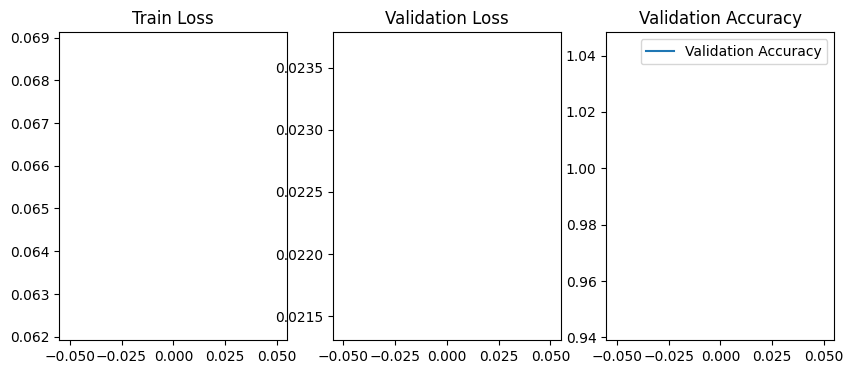

100%|██████████| 1798/1798 [01:56<00:00, 15.45batch/s, loss=0.00838]


Train loss: 0.021283166483044624
=> Saving checkpoint: 
/content/drive/Othercomputers/My MacBook Pro/My MIR Files/First Semester/Deep Learning/Image segmentation/HorizontalSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.01868431456387043
Got 116507941/117800960 with acc 98.90
Dice score: 0.9938505291938782


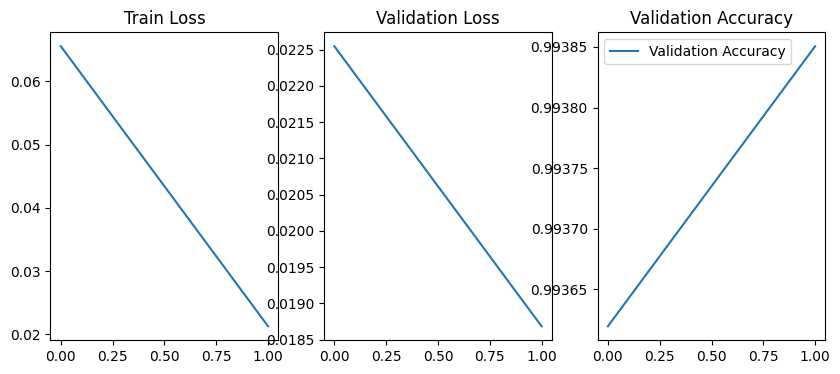

100%|██████████| 1798/1798 [01:54<00:00, 15.71batch/s, loss=0.0251]


Train loss: 0.017352424561977386
=> Saving checkpoint: 
/content/drive/Othercomputers/My MacBook Pro/My MIR Files/First Semester/Deep Learning/Image segmentation/HorizontalSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.010676616802811623
Got 116774362/117800960 with acc 99.13
Dice score: 0.9962210059165955


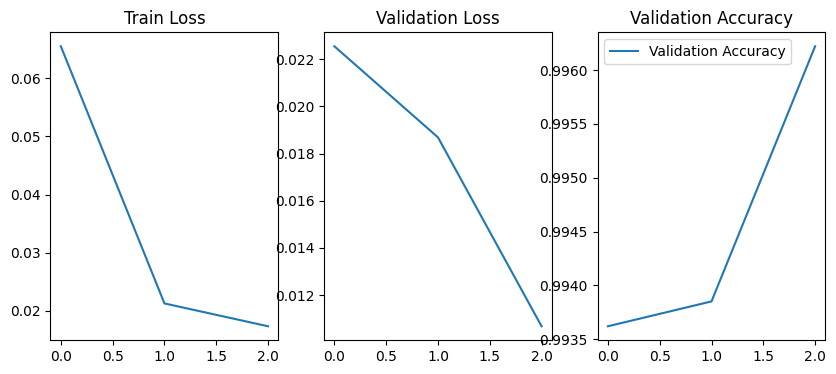

100%|██████████| 1798/1798 [01:53<00:00, 15.79batch/s, loss=0.00637]


Train loss: 0.013277526013553143
=> Saving checkpoint: 
/content/drive/Othercomputers/My MacBook Pro/My MIR Files/First Semester/Deep Learning/Image segmentation/HorizontalSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.008299319073557854
Got 116845592/117800960 with acc 99.19
Dice score: 0.9968546628952026


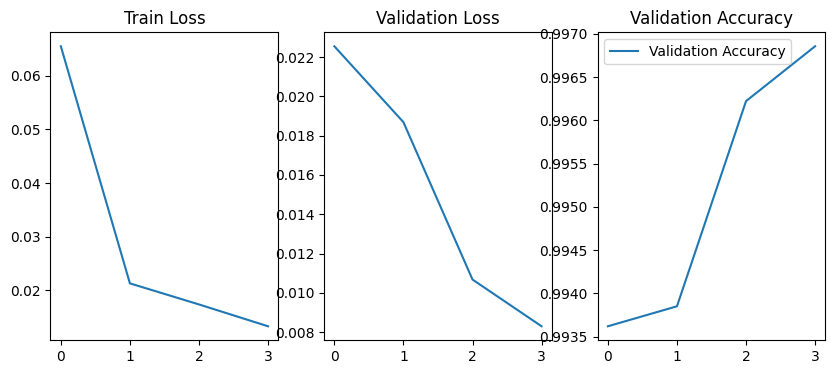

100%|██████████| 1798/1798 [01:55<00:00, 15.57batch/s, loss=0.0155]


Train loss: 0.012970502488315105
=> Saving checkpoint: 
/content/drive/Othercomputers/My MacBook Pro/My MIR Files/First Semester/Deep Learning/Image segmentation/HorizontalSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.008613025769591331
Got 116831337/117800960 with acc 99.18
Dice score: 0.9967076778411865


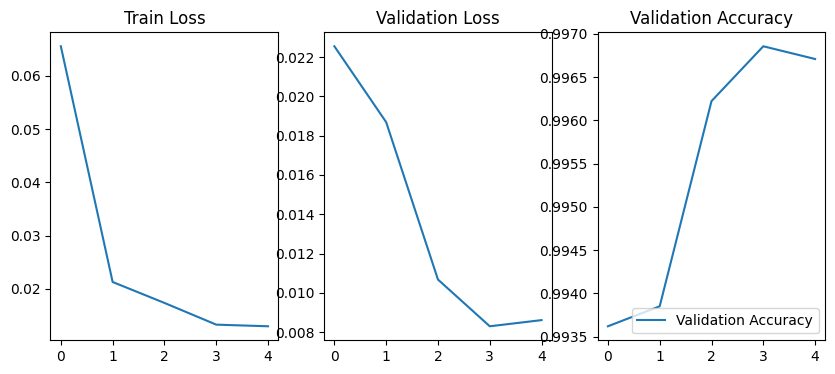

In [ ]:
hyper_parameters = HyperParameters(learning_rate = 1e-4, batch_size = 4, epoch_numbers = 5)
model= run_training(hyper_parameters)

# Evaluation

=> Loading checkpoint
y size : torch.Size([4, 1, 128, 256])
preds size: torch.Size([4, 1, 128, 256])


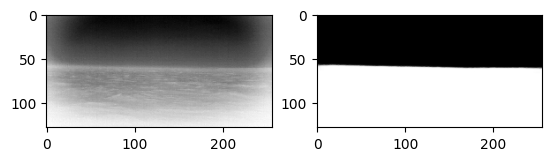

In [ ]:
import albumentations as A

load_checkpoint(torch.load(CHECKPOINT_PATH),model)
model.to(device=DEVICE)
val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_ds = HorizonDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transforms
    )

val_loader = DataLoader(
        val_ds,
        batch_size= 4,
        num_workers=2,
        pin_memory=True,
        shuffle=False
)

val_images, val_masks = next(iter(val_loader))

data = val_images
data = val_images.to('cuda')
y =model(data)

preds = torch.sigmoid(y)
print(f"y size : {y.size()}")
print(f"preds size: {preds.size()}")

preds = preds.detach().cpu().numpy()



f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(val_images[1][0], cmap="gray")
f.add_subplot(1,2, 2)
plt.imshow(preds[1][0], cmap="gray")
plt.show(block=True)

